In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from env_utils import PDUSession
from nfv_allocation_cpu_env import NfvAllocEnv
from sb3_contrib import MaskablePPO

2024-05-16 14:51:57.003703: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 14:51:57.005428: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 14:51:57.031114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 14:51:57.031139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 14:51:57.031796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
qi_dict = {3:0.6, 5:0.3, 9:0.1}
env_par={'config_file': 'nuc_host_models.json', 'metric':'power', 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
#seed = 1
n_steps = 10_000

env = NfvAllocEnv(**env_par)

f = open('5qi_table.json')
qi_table = json.load(f)

[<env_utils.EdgeHost object at 0x7fbd21dce830>, <env_utils.EdgeHost object at 0x7fbd21dce6b0>, <env_utils.EdgeHost object at 0x7fbd21dcda50>]


In [3]:
step_data = []
run_data = []

for seed in tqdm([10,11,12,13]):
    
    for gamma in tqdm([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]):

        path = f'saved models/PPO_scale1.5_env8_nuc_seed2_g{str(gamma%1)[2:]}_qi359_p631'
    
        drl_model = MaskablePPO.load(path)

        env.set_gamma(gamma)
        obs, info = env.reset(seed=seed)
    
        drl_lat_errors = []
        drl_rewards = []
        drl_powers = []
    
        for step in tqdm(range(n_steps)):
            mask = env.action_masks()
            action, _states = drl_model.predict(obs, action_masks=mask)
            obs, reward, _, _, info = env.step(action)
            drl_lat_errors.append(info['latency_error'])
            drl_rewards.append(reward)
            drl_powers.append(info['power_per_mbit'])
            step_data.append([seed, gamma, step, info['power_per_mbit']])
    
        run_data.append([seed, gamma, np.mean(drl_rewards), np.count_nonzero(drl_lat_errors)/n_steps*100, np.mean(drl_powers), np.median(drl_powers)] )
    
step_df = pd.DataFrame(step_data, columns=['seed', 'gamma', 'step','power'])
run_df = pd.DataFrame(run_data, columns=['seed', 'gamma', 'reward', 'error percent', 'mean power', 'median power'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

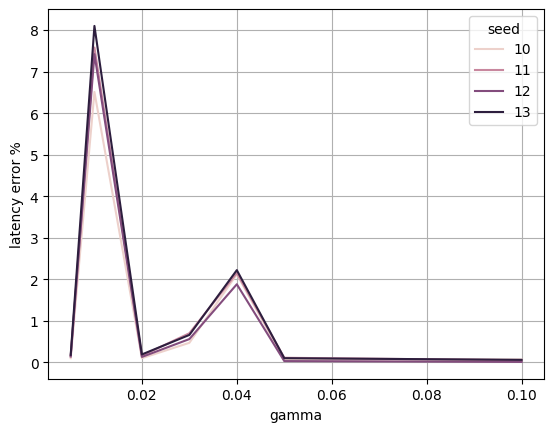

In [4]:
sns.lineplot(data=run_df, x='gamma', y='error percent', hue='seed')
plt.ylabel("latency error %")
plt.xlabel("gamma")
plt.grid()
plt.show()

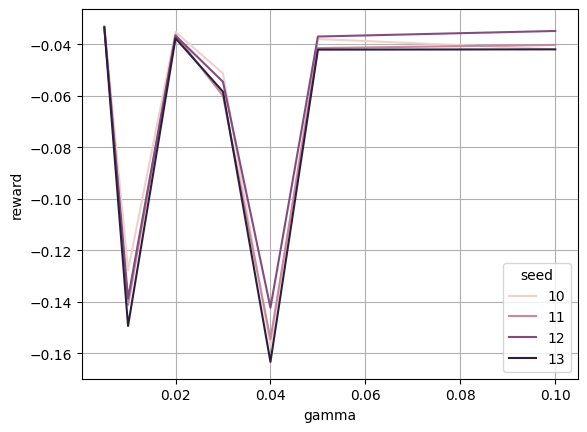

In [5]:
sns.lineplot(data=run_df, x='gamma', y='reward', hue='seed')
plt.ylabel("reward")
plt.xlabel("gamma")
plt.grid()
plt.show()

<Axes: ylabel='power'>

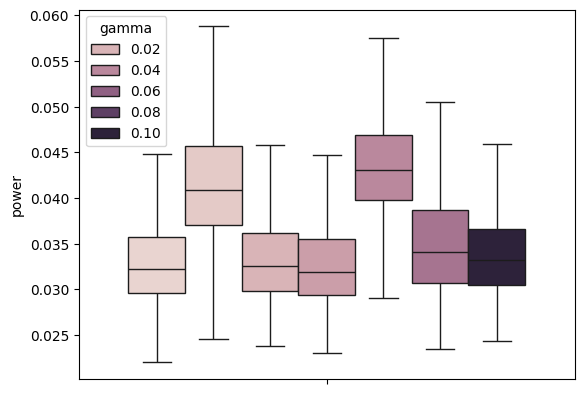

In [6]:
sns.boxplot(data=step_df, y="power", hue="gamma", showfliers=False)

(0.0, 0.1)

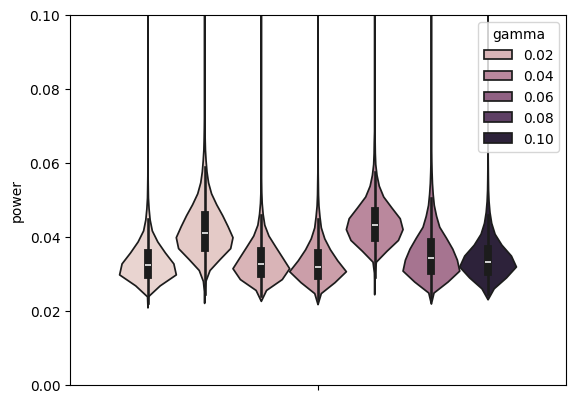

In [7]:
sns.violinplot(data=step_df, y="power", hue="gamma")
plt.ylim(0, 0.1)

(0.0, 0.1)

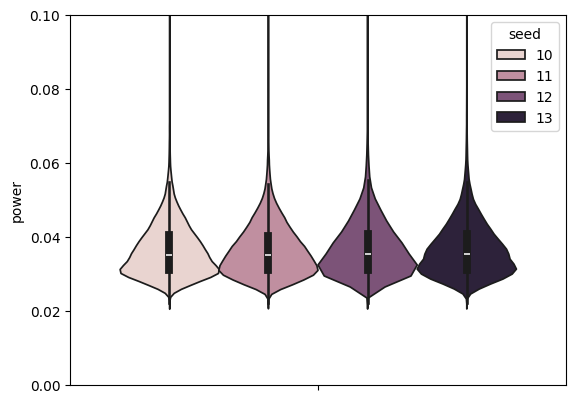

In [8]:
sns.violinplot(data=step_df, y="power", hue="seed")
plt.ylim(0, 0.1)

<Axes: xlabel='median power', ylabel='error percent'>

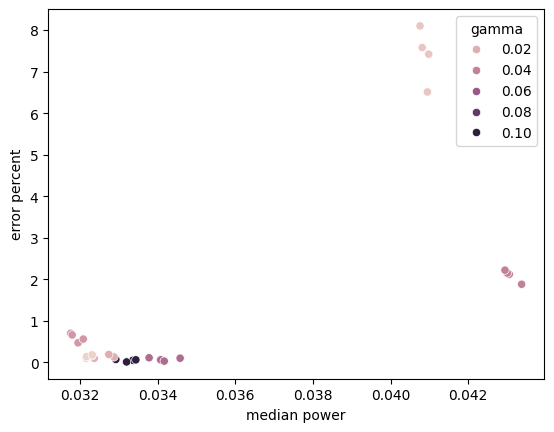

In [9]:
sns.scatterplot(data=run_df, x="median power", y="error percent", hue="gamma")